In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
sys.path.append('/home/jovyan/klenitskiy/repos/seqrec-experiments/')
sys.path.append('/home/jovyan/klenitskiy/repos/seqrec-datasets/')
sys.path.append('/home/jovyan/klenitskiy/repos/')
sys.path.append('/home/jovyan/klenitskiy/sparse_autoencoders/')
sys.path.append('/home/jovyan/klenitskiy/sparse_autoencoders/sae_recsys/')

In [2]:
!nvidia-smi

Thu Apr 10 15:04:12 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   30C    P0    84W / 400W |  27699MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   

In [3]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import seaborn as sns
import pytorch_lightning as pl
import torch
from nnsight import NNsight
from sklearn.feature_selection import chi2
from sklearn.metrics import explained_variance_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from seqrec_experiments.lightning.models import GPT4Rec, BERT4Rec
from seqrec_experiments.lightning.modules import SeqRec
from torch.utils.data import DataLoader, Dataset, IterableDataset

from seqrec_experiments.lightning.datasets import CausalLMDataset, PaddingCollateFn, CausalLMPredictionDataset
from seqrec_experiments.postprocess import preds2recs
from seqrec_experiments.metrics import Evaluator
from preprocessing.preparation import get_last_item, remove_last_item

from dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, JumpReluAutoEncoder, AutoEncoderNew
from dictionary_learning.trainers import StandardTrainer, GatedSAETrainer, TrainerTopK
from dictionary_learning.trainers.top_k import AutoEncoderTopK
from dictionary_learning.training import trainSAE

from sae_recsys.src.activations import extract_activations, get_block_activations, get_last_layer_activations, get_mlp_activations
from sae_recsys.src.analyze import analyze_feature, compute_hidden_stats, features_vs_neuron_stats
from sae_recsys.src.downstream import get_logit_diff_for_neuron, get_logit_diff_matrix
from sae_recsys.src.sae import run_sae, SAEIterableDataset
from sae_recsys.src.visualization import plot_activation_distr, plot_feature_vs_neuron, plot_neuron_fired_fraction, plot_num_active_neurons
from sae_recsys.src.activations import extract_activations, get_block_activations, get_last_layer_activations, get_mlp_activations
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from replay.metrics import OfflineMetrics, NDCG, HitRate, Novelty, Coverage, MRR, Precision
from jurity.recommenders import IntraListDiversity, InterListDiversity

In [4]:
import numpy as np
import pandas as pd
import rich
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, ModelSummary, RichProgressBar
from torch import nn
from torch.utils.data import DataLoader
from transformers import BertConfig, BertModel
from sklearn.preprocessing import LabelEncoder

from seqrec_experiments.metrics import Evaluator
from seqrec_experiments.lightning.datasets import MaskedLMDataset, MaskedLMPredictionDataset, PaddingCollateFn
from seqrec_experiments.lightning.models import BERT4Rec
from seqrec_experiments.lightning.modules import SeqRec
from seqrec_experiments.postprocess import preds2recs
from seqrec_experiments.utils import extract_validation_history

from preprocessing.preparation import get_last_item, remove_last_item

In [5]:
DATA_PATH = '/home/jovyan/mlruns/311478491323376785/7c9094befe4a444399dcb1ec705b23b7/artifacts/'
ITEM_FEATURES_PATH = '/home/jovyan/klenitskiy/sparse_autoencoders/results/ml-20m/item_features_raw.csv'

# Data

In [6]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
validation = pd.read_csv(os.path.join(DATA_PATH, 'train_sae.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

In [7]:
item_features = pd.read_csv(ITEM_FEATURES_PATH)

item_features = item_features.rename(columns={'movieId': 'item_id'})
#if 'year' not in item_features.columns:
#    item_features['year'] = item_features.title.map(lambda x: x.split('(')[-1][:4])

#item_features.item_id = item_features.item_id.map(item_mapping)
item_features = item_features[item_features.item_id.notnull()]
item_features.item_id = item_features.item_id.astype(int)

#item_features = item_features.join(item_features.genres.str.get_dummies())
# item_features = item_features.join(item_features.genres_ml1m.str.get_dummies())
#item_features.drop('(no genres listed)', axis=1, inplace=True)
print(item_features.shape)
item_features.head()

(27278, 23)


,item_id,title,genres,year,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train

,user_id,item_id,rating,timestamp
0,1,924,3.5,1094785598
1,1,919,3.5,1094785621
2,1,2683,3.5,1094785650
3,1,1584,3.5,1094785656
4,1,1079,4.0,1094785665
...,...,...,...,...
10753319,138493,6534,3.0,1260209908
10753320,138493,53464,4.0,1260209920
10753321,138493,1275,3.0,1262378552
10753322,138493,6996,3.0,1262378555


In [9]:
test_inputs = remove_last_item(test)
test_last_item = get_last_item(test)

# Train

In [10]:
MAX_LENGTH = 64
MLM_PROBABILITY = 0.2

VALIDATION_SIZE = None

BATCH_SIZE = 512
TEST_BATCH_SIZE = 512
NUM_WORKERS = 8

BERT_CONFIG = {
    'vocab_size': 2,
    'max_position_embeddings': 64,
    'hidden_size': 64,
    'num_hidden_layers': 2,
    'num_attention_heads': 2,
}

TRAINER_PARAMS = {
    'max_epochs': 100,
    'devices': 1,
    'enable_checkpointing': True,
}

LEARNING_RATE = 1e-3
PATIENCE = 10

In [11]:
vocab_size = train.item_id.max() + 1

In [12]:
train_dataset = MaskedLMDataset(train, max_length=MAX_LENGTH, time_col='timestamp',
                                mlm_probability=MLM_PROBABILITY,
                                force_last_item_masking_prob=0)

validation_users = validation.user_id.unique()
if VALIDATION_SIZE and (VALIDATION_SIZE < len (validation_users)):
    validation_users = np.random.choice(validation_users, size=VALIDATION_SIZE, replace=False)
    
eval_dataset = MaskedLMPredictionDataset(validation[validation.user_id.isin(validation_users)],
                                         max_length=MAX_LENGTH, validation_mode=True,
                                         time_col='timestamp')

collate_fn = PaddingCollateFn()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
eval_loader = DataLoader(
    eval_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

In [13]:
model = BERT4Rec(vocab_size, BERT_CONFIG, add_head=True, tie_weights=True)
model

BERT4Rec(
  (embed_layer): Embedding(92957, 64, padding_idx=0)
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(2, 64, padding_idx=0)
      (position_embeddings): Embedding(64, 64)
      (token_type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): La

In [14]:
model = model.to('cuda')

In [15]:
!nvidia-smi

Thu Apr 10 15:04:50 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   30C    P0    84W / 400W |  27699MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   

In [ ]:
seqrec_module = SeqRec(model, lr=LEARNING_RATE, predict_top_k=10)

early_stopping = EarlyStopping(monitor="val_ndcg", mode="max", patience=PATIENCE, verbose=False)
model_summary = ModelSummary(max_depth=4)
checkpoint = ModelCheckpoint(save_top_k=1, monitor="val_ndcg", mode="max", save_weights_only=True)
pbar = RichProgressBar()
callbacks=[early_stopping, model_summary, checkpoint, pbar]

trainer = pl.Trainer(callbacks=callbacks, accelerator="gpu", **TRAINER_PARAMS)

trainer.fit(model=seqrec_module,
            train_dataloaders=train_loader,
            val_dataloaders=eval_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

   | Name                                                     | Type           | Params
---------------------------------------------------------------------------------------------
0  | model                                                    | BERT4Rec       | 6.8

Output()

,step,val_ndcg,val_hit_rate,val_mrr,epoch,time
0,146,0.027335,0.058072,0.018093,0.0,0.000000
1,293,0.026599,0.057350,0.017418,1.0,66.433592
2,440,0.034371,0.071452,0.023181,2.0,132.664299
3,587,0.036661,0.074842,0.025206,3.0,199.214749
4,734,0.040692,0.082825,0.028049,4.0,265.241305
...,...,...,...,...,...,...
130,19256,0.144670,0.255958,0.110840,130.0,8946.325018
131,19403,0.142950,0.251745,0.109800,131.0,9015.853352
132,19550,0.142670,0.252909,0.109164,132.0,9085.139559
133,19697,0.142588,0.253049,0.108937,133.0,9154.722571


<Axes: title={'center': 'BERT4Rec'}, xlabel='epoch'>

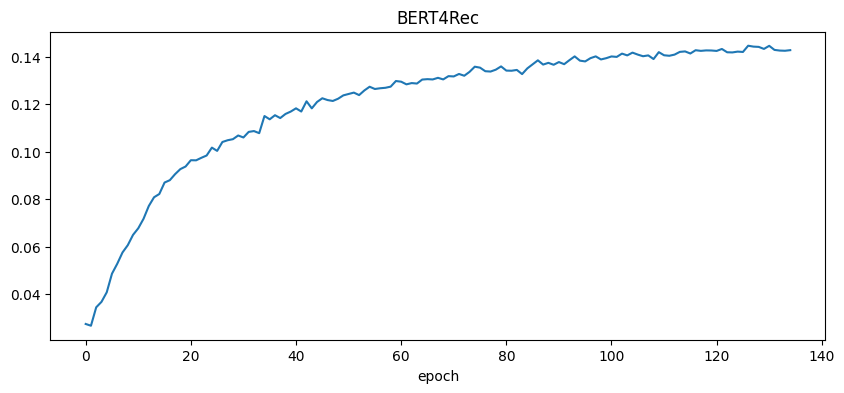

In [28]:
history = extract_validation_history(trainer.logger.experiment.log_dir)
display(history)
history.set_index('epoch')['val_ndcg'].plot(figsize=(10,4), title='BERT4Rec')

# Metrics

In [17]:
model = model.to('cpu')

In [18]:
#seqrec_module.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
import rich
predict_dataset = CausalLMPredictionDataset(test_inputs.dropna(), max_length=MAX_LENGTH, time_col='timestamp')

predict_loader = DataLoader(
    predict_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

preds = trainer.predict(model=seqrec_module, dataloaders=predict_loader)

recs = preds2recs(preds)
print(recs.shape)
recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Output()

(138500, 3)


,user_id,item_id,prediction
0,31,2081,7.870469
1,31,48,7.851303
2,31,595,7.793514
3,31,1907,7.379824
4,31,1022,7.366821


In [19]:
%%time
evaluator = Evaluator()
metrics = evaluator.compute_metrics(test_last_item, recs, train)
metrics

CPU times: user 11.5 s, sys: 3.74 s, total: 15.3 s
Wall time: 15.3 s


{'map@10': 0.06481024010085382,
 'ndcg@10': 0.0876415151510417,
 'recall@10': 0.16310469314079423,
 'precision@10': 0.01631046931407942,
 'coverage@10': 0.23290745856353592,
 'entropy@10': 9.75052319299922,
 'novelty@10': 11.321294861929893}

In [28]:
# torch.save(seqrec_module.model, os.path.join(MODEL_SAVE_PATH, 'gpt_64_1_1.pt'))
torch.save(seqrec_module.model, 'bert_128_2_2_maxlen_128.pt')

# SAE

In [96]:
model = torch.load('bert_64_3_2_maxlen_64.pt', weights_only=False)
model.eval()

BERT4Rec(
  (embed_layer): Embedding(92957, 64, padding_idx=0)
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(2, 64, padding_idx=0)
      (position_embeddings): Embedding(64, 64)
      (token_type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): La

In [20]:
MAX_LENGTH = 64
BATCH_SIZE_GPT = 125
NUM_WORKERS = 8

train_dataset = CausalLMDataset(validation, max_length=MAX_LENGTH, time_col='timestamp')
test_dataset = CausalLMDataset(test, max_length=MAX_LENGTH, time_col='timestamp')

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE_GPT,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE_GPT,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

batch_gpt = next(iter(train_loader))
print(batch_gpt['input_ids'].shape)

torch.Size([125, 64])


In [25]:
def extract_activations(model, dataloader, get_activations_fn, layer_number=0):

    model.eval()
    nsight_model = NNsight(model)
    users, items, activations = [], [], []

    for batch in tqdm(dataloader):

        with nsight_model.trace(batch['input_ids'], batch['attention_mask']) as tracer:
            try:
                batch_activations = get_activations_fn(nsight_model, layer_number=layer_number)
            except TypeError:
                batch_activations = get_activations_fn(nsight_model)

        batch_activations = batch_activations.view(-1, batch_activations.shape[2])
        batch_users = torch.repeat_interleave(
            batch['user_id'][:, None], repeats=batch['input_ids'].shape[1], dim=1)
        batch_users = batch_users.flatten()
        batch_items = batch['input_ids'].flatten()

        batch_activations = batch_activations[batch_items != 0]
        batch_users = batch_users[batch_items != 0]
        batch_items = batch_items[batch_items != 0]

        activations.append(batch_activations.detach().cpu().numpy())
        users.append(batch_users.detach().cpu().numpy())
        items.append(batch_items.detach().cpu().numpy())

    return pd.DataFrame({'user_id': np.hstack(users),
                         'item_id': np.hstack(items),
                         'activation': list(np.vstack(activations))
                        })


def get_last_layer_activations(nsight_model):

    transformer_outputs = nsight_model.transformer_model.output
    activations = transformer_outputs.last_hidden_state.save()

    return activations


def get_block_activations(nsight_model, layer_number=0):

    activations = nsight_model.transformer_model.encoder.layer[layer_number].output[0].output.save()
    # nsight_model.transformer_model.h[layer_number].output[0].stop()  # possibly work in new version only

    return activations


In [35]:
get_activations_fn = get_block_activations
model.to('cuda')
activations_train = extract_activations(model, train_loader, get_activations_fn=get_activations_fn, layer_number=0)
activations_test = extract_activations(model, test_loader, get_activations_fn=get_activations_fn, layer_number=0)

100%|██████████| 399/399 [00:23<00:00, 16.87it/s]
/home/jovyan/denisova/env/denisova_seqrec/lib/python3.9/site-packages/nnsight/envoy.py:104: UserWarning: Module of type `<class 'transformers.models.bert.modeling_bert.BertAttention'>` has pre-defined a `output` attribute. nnsight access for `output` will be mounted at `.nns_output` instead of `.output` for this module only.
  warnings.warn(
/home/jovyan/denisova/env/denisova_seqrec/lib/python3.9/site-packages/nnsight/envoy.py:104: UserWarning: Module of type `<class 'transformers.models.bert.modeling_bert.BertLayer'>` has pre-defined a `output` attribute. nnsight access for `output` will be mounted at `.nns_output` instead of `.output` for this module only.
  warnings.warn(
100%|██████████| 111/111 [00:07<00:00, 15.15it/s]


In [36]:
activations_array = np.array(activations_train.activation.tolist())
mean, std = activations_array.mean(), activations_array.std()
activations_test['normed'] = activations_test.activation.map(lambda x: (x - mean) / std)
activations_train['normed'] = activations_train.activation.map(lambda x: (x - mean) / std)

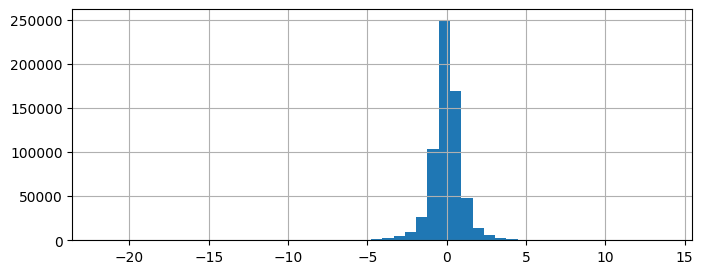

In [37]:
array = np.array(list(activations_train.normed))
fig = plot_activation_distr(array, low_value=array.min(), clip_quantile=1, figsize=(8, 3), sample_size=10000)

In [29]:
BATCH_SIZE_SAE = 256

sae_train_dataset = SAEIterableDataset(activations_train.normed)
sae_train_loader = DataLoader(
    sae_train_dataset, batch_size=BATCH_SIZE_SAE,
    num_workers=NUM_WORKERS)

batch_sae = next(iter(sae_train_loader))
print(batch_sae.shape)

torch.Size([256, 64])


In [38]:
trainer_cfg = {
    "trainer": StandardTrainer,
    "dict_class": AutoEncoder,
    "activation_dim": 64,
    "dict_size": 4128,
    "lr": 1e-4,
    "l1_penalty": 1e-1,
    "warmup_steps" : 100,
    "resample_steps" : None,
    "layer": "layer",
    "lm_name": "BERT"
}

ae, logs = trainSAE(
    data=sae_train_loader,
    trainer_configs=[trainer_cfg],
    steps=100000,
    log_steps=500,
)

100%|██████████| 100000/100000 [03:30<00:00, 475.42it/s]


In [39]:
pd.DataFrame(logs)

,StandardTrainer-0/frac_variance_explained,StandardTrainer-0/l2_loss,StandardTrainer-0/mse_loss,StandardTrainer-0/sparsity_loss,StandardTrainer-0/loss,StandardTrainer-0/l0
0,-7.393972,25.687876,732.185303,919.703369,117.658211,2071.695312
1,0.630623,4.422851,21.164503,272.167236,31.639576,1295.714844
2,0.738776,3.868502,16.721127,57.392036,9.607706,436.933594
3,0.791833,3.419346,13.069540,28.839737,6.303320,212.789062
4,0.871413,2.826020,8.700729,24.136543,5.239675,145.964844
...,...,...,...,...,...,...
195,0.983972,0.900929,0.897100,20.394772,2.940406,179.054688
196,0.985314,0.932383,0.960055,22.164433,3.148826,184.902344
197,0.985282,0.898633,0.890712,21.009655,2.999599,182.214844
198,0.985067,0.919312,0.930764,21.335978,3.052910,182.894531


<Axes: >

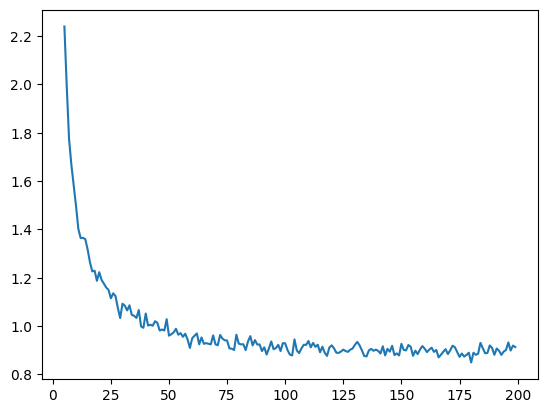

In [40]:
pd.DataFrame(logs)['StandardTrainer-0/l2_loss'][5:].plot()

In [44]:
torch.save(ae, 'sae_bert_128.pt')

In [41]:
reconstruction, hidden = run_sae(ae, activations_test, activation_col='normed',
                                     batch_size=256, num_workers=NUM_WORKERS)
print(reconstruction.shape, hidden.shape)

(648294, 64) (648294, 4128)


In [42]:
activation_values = np.array(activations_test.normed.tolist())

print('explained variance', explained_variance_score(activation_values, reconstruction))
print('mae', mean_absolute_error(activation_values, reconstruction))
print('rmse', root_mean_squared_error(activation_values, reconstruction))

explained variance 0.9771095514297485
mae 0.09592972
rmse 0.12535873


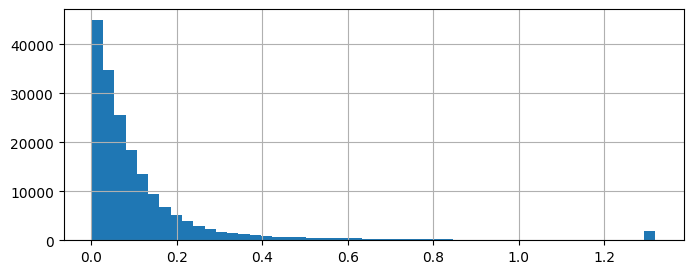

In [43]:
fig = plot_activation_distr(hidden, low_value=0.001, clip_quantile=0.99, figsize=(8, 3), sample_size=1000)

In [44]:
THRESHOLDS = [0, 0.1, 0.5, 1]

num_active_neurons, neuron_fired_fraction = compute_hidden_stats(hidden, thresholds=THRESHOLDS)
num_dead_neurons = (neuron_fired_fraction[0] == 0).sum()
print('num_dead_neurons', num_dead_neurons)

num_dead_neurons 1393


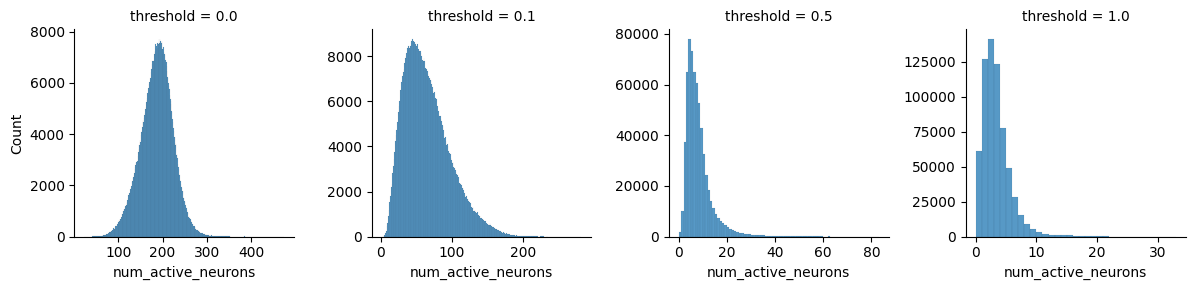

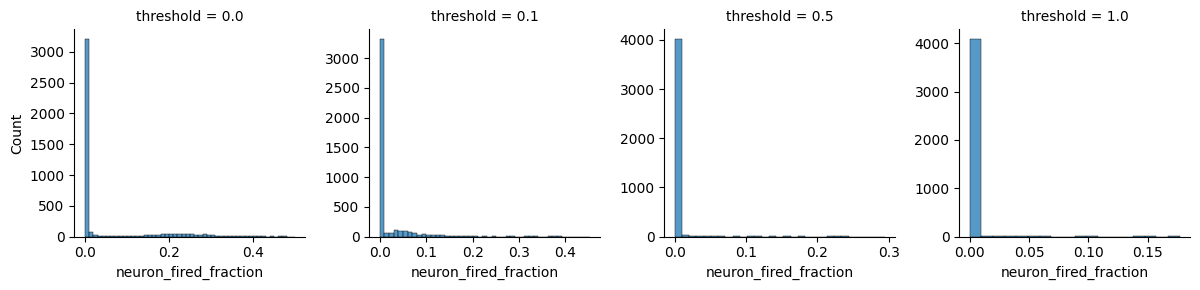

In [45]:
fig = plot_num_active_neurons(num_active_neurons, col_wrap=6, height=3, sharey=False, sharex=False)
fig = plot_neuron_fired_fraction(neuron_fired_fraction, col_wrap=6, height=3, cumulative=False, sharey=False, sharex=False)

In [46]:
num_active_neurons.describe()

,0.0,0.1,0.5,1.0
count,648294.000000,648294.000000,648294.000000,648294.000000
mean,186.605295,64.443624,7.799168,2.911020
std,36.392743,32.487711,5.909120,2.380554
min,24.000000,1.000000,0.000000,0.000000
25%,164.000000,40.000000,4.000000,1.000000
50%,188.000000,59.000000,6.000000,2.000000
75%,211.000000,84.000000,9.000000,4.000000
max,474.000000,282.000000,83.000000,33.000000


In [47]:
features = pd.merge(activations_test, item_features, how='left', on='item_id')
feature_cols = features.loc[:, 'Action':].columns
features = features[feature_cols]
print(features.shape)
features.head()

(648294, 19)


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [53]:
chi2_stats = analyze_feature(hidden, features, feature_name='Action')

Analyze feature: Action
Number of examples with feature 287487
Fraction of examples with feature 0.3116782164478135
Top neurons according to chi2 statistics
171    142263.089310
44      39044.423244
421     33071.475213
54      31151.208065
981     20924.067149
541     20440.976289
115     20359.267466
24      18989.637122
198     18518.651609
149     18192.342799
Name: chi2, dtype: float64
Stats for top neuron
Neuron id 171
When feature is on:
Average neuron activation 0.3004222
Number of examples with fired neuron 95083
Fraction of examples with fired neuron 0.33073843339003156
When feature is off:
Average neuron activation 0.021349834
Average top neuron activation for other features
Action       0.300422
Adventure    0.211271
IMAX         0.208911
Thriller     0.173647
Sci-Fi       0.168562
Western      0.162690
War          0.149396
Crime        0.126446
Fantasy      0.106212
Drama        0.062813
dtype: float32


In [62]:
%%time
mean_neuron_activation, fraction_neuron_fired, neuron_feature_corr, neuron_feature_rocauc, pricision = features_vs_neuron_stats(hidden, features)

precision computation: 100%|██████████| 4128/4128 [00:35<00:00, 117.44it/s]


CPU times: user 59.3 s, sys: 12.2 s, total: 1min 11s
Wall time: 1min 50s


In [134]:
feature_to_sort = 'Children'

In [58]:
pd.set_option('display.max_columns', 50)

# feature_to_sort = 'Animation'
feature_to_sort = 'Action'
# feature_to_sort = 'Sci-Fi'
#feature_to_sort = 'Thriller'
# feature_to_sort = 'Romance'
# feature_to_sort = 'Fantasy'
# feature_to_sort = 'Horror'
#feature_to_sort = 'Western' 
# feature_to_sort = 'Drama'
mean_neuron_activation_top = mean_neuron_activation.sort_values(feature_to_sort, ascending=False).head(10)
mean_neuron_activation_top

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
18,0.440218,0.384448,0.404899,0.289868,0.334301,0.492814,0.718457,0.527347,0.320520,-0.083294,0.308618,1.544808,0.238339,0.593730,0.453412,0.587275,0.377326,0.617343,-0.089282
29,0.421247,0.423477,0.753440,0.600159,0.427546,0.444028,0.959598,0.494327,0.433047,0.682119,0.257977,0.522054,0.404813,0.583932,0.519658,0.469028,0.436958,0.473570,0.434096
60,0.341439,0.301996,0.129839,0.155615,-0.004686,0.145509,-0.382620,0.046786,0.171168,-0.373700,-0.068213,0.605124,-0.129877,0.160623,-0.055305,0.312746,0.162158,0.269537,0.028262
23,0.332213,0.121410,0.194382,0.078464,0.176605,0.483966,0.689345,0.434403,0.030205,0.444896,0.224182,0.245686,0.103218,0.478671,0.269520,0.388559,0.414896,0.650879,0.361466
43,0.306294,0.325121,0.162852,0.130702,0.152054,0.251755,0.303080,0.206556,0.306032,0.452508,0.013480,0.129855,-0.015238,0.262654,0.072662,0.270304,0.241792,0.221842,0.403588
22,0.267862,0.354579,0.493368,0.521430,0.220411,0.041871,-0.450050,0.097845,0.455958,-0.485034,0.295058,0.690933,0.408328,0.154803,0.288807,0.277521,0.173021,0.088800,-0.047688
48,0.266154,0.190937,0.268033,0.137660,0.193308,0.302006,0.531462,0.223190,0.270223,0.107786,0.383973,0.587531,0.049525,0.355146,0.085559,0.254960,0.299135,0.216003,0.287471
55,0.243579,0.289082,0.381297,0.335592,0.102290,0.249400,0.052685,0.221716,0.340575,0.328146,-0.030456,0.353482,0.106800,0.334955,0.262079,0.246615,0.244287,0.319670,0.092118
25,0.213206,0.186234,0.304041,0.285810,0.160744,0.204667,0.027365,0.162604,0.166283,0.123407,0.128717,0.375690,0.082817,0.141946,0.229109,0.082667,0.138548,0.162991,-0.023597
27,0.209997,0.323147,0.231419,0.123045,0.129184,0.208733,0.180353,0.247489,0.425373,0.233589,0.172196,0.280908,0.105606,0.283911,0.275126,0.263605,0.190730,0.193231,0.083022


In [56]:
fraction_neuron_fired.sort_values(feature_to_sort, ascending=False).head(10)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
798,0.842273,0.847467,0.841636,0.792906,0.814151,0.871324,0.838629,0.848902,0.882299,0.869954,0.713433,0.956657,0.671776,0.861219,0.859916,0.810641,0.839171,0.773612,0.882415
1672,0.509657,0.618560,0.673065,0.639003,0.708849,0.534237,0.893542,0.562282,0.603517,0.698958,0.339987,0.478002,0.657052,0.402386,0.571703,0.506969,0.410255,0.596469,0.824043
1662,0.669976,0.657599,0.597174,0.655123,0.649721,0.679862,0.160053,0.626950,0.586478,0.456774,0.312104,0.646269,0.598761,0.564135,0.654536,0.625433,0.592200,0.749040,0.815103
1513,0.470212,0.514726,0.443267,0.471197,0.485030,0.432126,0.737150,0.534676,0.579355,0.435931,0.499315,0.611349,0.505109,0.493232,0.543161,0.490790,0.422405,0.634243,0.797749
1889,0.784015,0.734592,0.811938,0.747070,0.783928,0.838667,0.899985,0.829461,0.785967,0.846176,0.802914,0.892297,0.710154,0.810011,0.793439,0.822779,0.803811,0.832218,0.797118
341,0.466440,0.512956,0.445283,0.471860,0.484877,0.426792,0.736565,0.532142,0.579229,0.421107,0.497154,0.607804,0.503781,0.486340,0.541769,0.489356,0.417422,0.630326,0.795015
145,0.499026,0.434515,0.452716,0.423857,0.489754,0.504069,0.571972,0.536853,0.386613,0.619404,0.506982,0.479636,0.419865,0.478107,0.507023,0.480460,0.476665,0.532572,0.762936
132,0.451032,0.441290,0.389123,0.504357,0.417447,0.362680,0.601845,0.408731,0.377027,0.515632,0.406580,0.403912,0.602462,0.413145,0.320289,0.441481,0.417016,0.418818,0.744846
559,0.542744,0.598464,0.397907,0.415596,0.522856,0.474051,0.217894,0.472749,0.643340,0.495230,0.481376,0.413968,0.589830,0.462638,0.525810,0.502419,0.482120,0.542543,0.744215
1695,0.613928,0.601113,0.613281,0.631566,0.621431,0.687068,0.576951,0.674968,0.586068,0.869808,0.811093,0.474432,0.583313,0.672166,0.611868,0.637868,0.660587,0.582454,0.736748


In [63]:
feature_to_sort = 'Sci-Fi'
neuron_feature_corr.sort_values(feature_to_sort, ascending=False).head(10)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
2593,0.124132,0.057174,0.006662,-0.046542,-0.127086,-0.088438,-0.016168,-0.071053,-0.016003,-0.007275,0.108098,0.080643,-0.036330,0.058169,-0.070414,0.418799,0.108728,-0.034373,-0.017376
835,0.085816,0.041049,-0.022271,-0.041159,-0.073381,-0.063473,-0.016620,-0.062359,-0.035089,-0.000149,0.064042,0.032406,-0.025356,0.021930,-0.052468,0.310143,0.068790,-0.037508,-0.006793
1020,0.047370,0.004010,0.030976,-0.019135,-0.073472,-0.050351,0.050876,-0.023022,-0.021019,-0.009438,0.064637,0.074433,-0.007994,0.060809,-0.037246,0.248147,0.030583,-0.024785,0.032374
3808,0.144145,0.023862,-0.070457,-0.083095,-0.090211,-0.011371,-0.021422,-0.036189,-0.041741,-0.023966,0.025600,0.049829,-0.060375,0.034021,-0.043403,0.199443,0.164117,0.020807,-0.017252
302,0.120908,0.058686,-0.010708,-0.043109,-0.023902,-0.023588,-0.035070,-0.051973,-0.010510,-0.012234,0.016800,0.081640,-0.040065,0.067496,-0.037534,0.190020,0.127565,-0.030830,-0.031225
263,0.145470,0.104435,0.001410,-0.037271,-0.092985,-0.018871,-0.022933,-0.034883,-0.000640,0.003532,0.002242,0.018960,-0.039331,0.040226,-0.047060,0.184687,0.102562,-0.002144,-0.023650
1017,0.098119,0.062864,-0.034295,-0.035564,-0.017128,-0.053377,-0.016199,-0.082736,-0.030013,-0.031454,0.016800,-0.004658,-0.025439,-0.044026,-0.043801,0.164270,0.000984,0.013597,0.018005
3767,0.126079,0.143515,-0.009206,-0.011733,-0.050164,-0.047583,-0.007699,-0.093923,-0.017666,-0.009951,-0.028180,-0.025723,-0.018335,-0.034130,-0.021781,0.163897,-0.049917,-0.022711,-0.010549
3330,0.078741,0.073082,-0.035135,-0.045036,-0.014108,-0.057283,-0.015477,-0.048621,-0.010802,-0.014719,0.007162,-0.001318,-0.031150,-0.035956,-0.021497,0.148160,0.006026,0.001269,-0.007545
464,0.127394,0.194205,0.030312,0.040450,-0.045920,-0.045000,0.002065,-0.128635,0.076813,0.004448,-0.005262,0.065223,-0.024260,0.004118,-0.037327,0.136284,-0.022039,-0.044901,0.001018


In [59]:
roc_auc_max = neuron_feature_rocauc.max(axis=0).round(3).rename('max roc auc')
correlation_max = neuron_feature_corr.max(axis=0).round(3).rename('max correlation')
fraction_max = fraction_neuron_fired.max(axis=0).round(3).rename('max fraction')
mean_activation_max = mean_neuron_activation.max(axis=0).round(3).rename('max mean activation')
max_by_feature_sae = roc_auc_max.to_frame().join(correlation_max).join(fraction_max).join(mean_activation_max)
max_by_feature_sae

,max roc auc,max correlation,max fraction,max mean activation
Action,0.603,0.168,0.705,0.440
Adventure,0.593,0.147,0.710,0.423
Animation,0.675,0.173,0.799,0.753
Children,0.680,0.163,0.802,0.600
Comedy,0.613,0.190,0.647,0.428
Crime,0.625,0.164,0.720,0.493
Documentary,0.767,0.121,0.893,1.083
Drama,0.597,0.172,0.702,0.527
Fantasy,0.638,0.158,0.733,0.456
Film-Noir,0.677,0.086,0.868,0.783


In [60]:
max_by_feature_sae.describe()

,max roc auc,max correlation,max fraction,max mean activation
count,19.000000,19.000000,19.000000,19.000000
mean,0.641158,0.139158,0.748053,0.614211
std,0.048779,0.038851,0.068866,0.279865
min,0.584000,0.050000,0.647000,0.408000
25%,0.608000,0.113500,0.700500,0.447500
50%,0.627000,0.150000,0.733000,0.520000
75%,0.671500,0.166000,0.777000,0.625500
max,0.767000,0.191000,0.893000,1.545000


In [73]:
max_by_feature.to_csv('bert_sae_max_by_feature.csv')

In [75]:
12

12

In [51]:
%%time
mean_neuron_activation, fraction_neuron_fired, neuron_feature_corr, neuron_feature_rocauc, pricision = features_vs_neuron_stats(np.array(activations_test.normed.values.tolist()), features)

precision computation: 100%|██████████| 64/64 [00:01<00:00, 38.07it/s]

CPU times: user 3.08 s, sys: 397 ms, total: 3.48 s
Wall time: 4.45 s


In [52]:
roc_auc_max = neuron_feature_rocauc.max(axis=0).round(3).rename('max roc auc')
correlation_max = neuron_feature_corr.max(axis=0).round(3).rename('max correlation')
fraction_max = fraction_neuron_fired.max(axis=0).round(3).rename('max fraction')
mean_activation_max = mean_neuron_activation.max(axis=0).round(3).rename('max mean activation')
max_by_feature = roc_auc_max.to_frame().join(correlation_max).join(fraction_max).join(mean_activation_max)
max_by_feature

,max roc auc,max correlation,max fraction,max mean activation
Action,0.603,0.168,0.705,0.440
Adventure,0.593,0.147,0.710,0.423
Animation,0.675,0.173,0.799,0.753
Children,0.680,0.163,0.802,0.600
Comedy,0.613,0.190,0.647,0.428
Crime,0.625,0.164,0.720,0.493
Documentary,0.767,0.121,0.893,1.083
Drama,0.597,0.172,0.702,0.527
Fantasy,0.638,0.158,0.733,0.456
Film-Noir,0.677,0.086,0.868,0.783


In [53]:
max_by_feature.describe()

,max roc auc,max correlation,max fraction,max mean activation
count,19.000000,19.000000,19.000000,19.000000
mean,0.641158,0.139158,0.748053,0.614211
std,0.048779,0.038851,0.068866,0.279865
min,0.584000,0.050000,0.647000,0.408000
25%,0.608000,0.113500,0.700500,0.447500
50%,0.627000,0.150000,0.733000,0.520000
75%,0.671500,0.166000,0.777000,0.625500
max,0.767000,0.191000,0.893000,1.545000


In [54]:
max_corr_original = max_by_feature['max correlation'].reset_index()
max_corr_original.columns = ['Genre', 'Correlation']
max_corr_original['Neuron'] = 'Original'

max_corr_sae = max_by_feature_sae['max correlation'].reset_index()
max_corr_sae.columns = ['Genre', 'Correlation']
max_corr_sae['Neuron'] = 'SAE'

max_corr = pd.concat([max_corr_original, max_corr_sae])

In [55]:
max_corr

,Genre,Correlation,Neuron
0,Action,0.168,Original
1,Adventure,0.147,Original
2,Animation,0.173,Original
3,Children,0.163,Original
4,Comedy,0.190,Original
5,Crime,0.164,Original
6,Documentary,0.121,Original
7,Drama,0.172,Original
8,Fantasy,0.158,Original
9,Film-Noir,0.086,Original


/tmp/ipykernel_153525/665646165.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right', size=12)


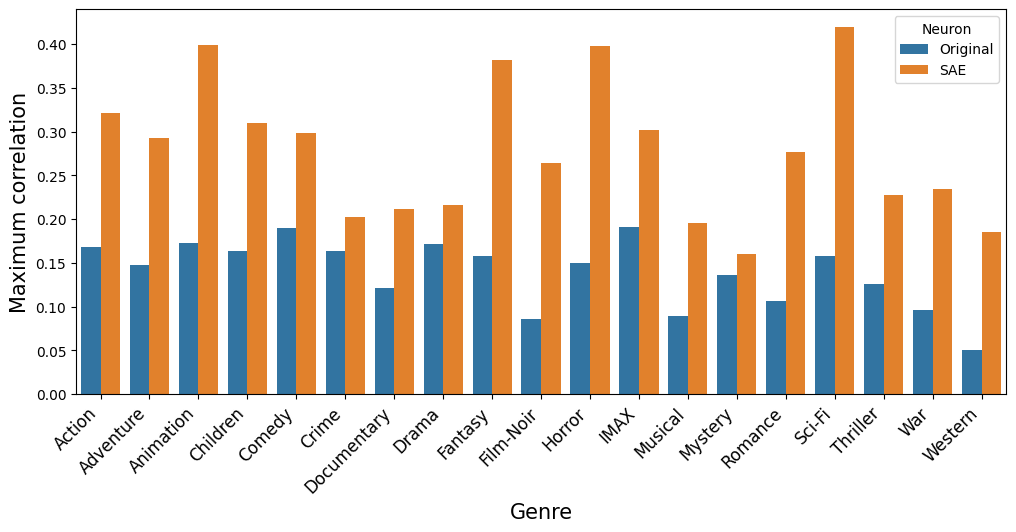

In [56]:
plt.figure(figsize=(12, 5))
barplot = sns.barplot(max_corr, x='Genre', y='Correlation', hue='Neuron')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right', size=12)
barplot.set_xlabel('Genre', fontsize=15)
barplot.set_ylabel("Maximum correlation", fontsize=15)

plt.show()

# Управление

In [64]:
test_last = get_last_item(test)
test_pred = remove_last_item(test)

In [65]:
predict_dataset = CausalLMPredictionDataset(test_pred, max_length=64, time_col='timestamp')

predict_loader = DataLoader(
    predict_dataset, batch_size=256, shuffle=False,
    num_workers=8, collate_fn=PaddingCollateFn())

In [71]:
results_norm = dict()
neuron_id = {'Children': 3678, 'Action': 280, 'Sci-Fi': 2593}

for genre in ['Sci-Fi']:
    for j in range(-10, 11, 2):
        #vector = models_genres[genre].coef_[0] * j / np.linalg.norm(models_genres[genre].coef_[0])
        nsight_model = NNsight(seqrec_module.model)
        layer_number = 0
        layer = 'block'
        result = pd.DataFrame({'user_id': [], 'item_id': [], 'prediction': []})

        for batch in tqdm(predict_loader): 
            rows_ids = torch.arange(batch['input_ids'].shape[0])
            matrix = torch.zeros((batch['input_ids'].shape[0], model.head.out_features))
            last_item_idx = []

            for i, indices in enumerate(batch['full_history']):
                 indices = np.trim_zeros(indices.numpy(), trim='b')
                 matrix[i, indices] = -float('Inf')
                 last_item_idx.append(min(len(indices) - 1, batch['input_ids'].shape[1] - 1))

            with nsight_model.trace(batch['input_ids'], batch['attention_mask']) as tracer:
                layer_output = nsight_model.transformer_model.encoder.layer[layer_number].output[0].output
                activations = layer_output[rows_ids, last_item_idx, :]
                activations = (activations - mean) / std
                latent_features = ae.encode(activations)
                latent_features[:, neuron_id[genre]] += j
                reconstructed_activations = ae.decode(latent_features)
                activations = reconstructed_activations * std + mean
                layer_output[rows_ids, last_item_idx, :] = reconstructed_activations

                model_outputs_after = nsight_model.head.output.save()

            outputs = model_outputs_after.detach().cpu()
            #print(model(batch['input_ids'], batch['attention_mask']) == outputs)
            outputs = outputs[rows_ids, last_item_idx, :]

            outputs = outputs + matrix
            
            prediction, item_id = outputs.sort(dim=1, descending=True) 
            prediction = prediction[:, :10]
            item_id = item_id[:, :10]

            table = pd.DataFrame({'user_id': np.ravel(np.tile(batch['user_id'], (10, 1)), order='F'),
                                  'item_id': item_id.flatten(),
                                  'prediction': prediction.flatten()})
            result = pd.concat([result, table])

        result['user_id'] = result['user_id'].astype(int)
        result['item_id'] = result['item_id'].astype(int)
        
        
        all_metrics = [NDCG(10), HitRate(10),
                   Novelty(10), Coverage(10),
                   MRR(10), Precision(10)]
        metric = OfflineMetrics(all_metrics, query_column='user_id',
                                rating_column='prediction')(result, test_last, train)


        metric[f'Inter-List Diversity{10}'] = InterListDiversity(click_column='prediction',
                                                                                        k=10).get_score(test_pred, result)
        
        #features = pd.read_csv(ITEM_FEATURES_PATH)
        features_columns = item_features.loc[:, 'Action':].columns

        reconstructed = pd.merge(result, item_features, how='left', on='item_id')
        d = {feature: 'mean' for feature in features_columns}
        original_table = reconstructed.groupby(by='user_id').agg(d).rename(columns={i: f'{i}_reconstructed' for i in features_columns}).mean(axis=0)
        
        results_norm[(genre, j)] = {**metric, **original_table.to_dict()}

/home/jovyan/denisova/env/denisova_seqrec/lib/python3.9/site-packages/nnsight/envoy.py:104: UserWarning: Module of type `<class 'transformers.models.bert.modeling_bert.BertAttention'>` has pre-defined a `output` attribute. nnsight access for `output` will be mounted at `.nns_output` instead of `.output` for this module only.
  warnings.warn(
/home/jovyan/denisova/env/denisova_seqrec/lib/python3.9/site-packages/nnsight/envoy.py:104: UserWarning: Module of type `<class 'transformers.models.bert.modeling_bert.BertLayer'>` has pre-defined a `output` attribute. nnsight access for `output` will be mounted at `.nns_output` instead of `.output` for this module only.
  warnings.warn(
100%|██████████| 55/55 [02:47<00:00,  3.05s/it]
/home/jovyan/denisova/env/denisova_seqrec/lib/python3.9/site-packages/replay/metrics/offline_metrics.py:375: UserWarning: train contains queries that are not presented in recommendations
  warnings.warn(f"{dataset_name} contains queries that are not presented in recom

In [72]:
pd.DataFrame(results_norm)

Sci-Fi                                          \
                                -10       -8        -6        -4        -2    
NDCG@10                    0.078795  0.082967  0.086615  0.089781  0.092249   
HitRate@10                 0.147509  0.154368  0.160289  0.164332  0.167798   
Novelty@10                 1.000000  1.000000  1.000000  1.000000  1.000000   
Coverage@10                0.175875  0.188421  0.202233  0.216851  0.230087   
MRR@10                     0.058107  0.061467  0.064393  0.067225  0.069345   
Precision@10               0.014751  0.015437  0.016029  0.016433  0.016780   
Inter-List Diversity10     0.958916  0.963578  0.967686  0.971142  0.973663   
Action_reconstructed       0.203610  0.221755  0.242996  0.264816  0.289928   
Adventure_reconstructed    0.159942  0.172209  0.185942  0.200650  0.215769   
Animation_reconstructed    0.051942  0.055386  0.058542  0.061711  0.063978   
Children_reconstructed     0.064347  0.067184  0.069495  0.071487  0.072296   
Comedy_reconstructed       0.342599  0.345379  0.344881  0.341285  0.333610   
Crime_reconstructed        0.291155  0.283841  0.275964  0.266022  0.254542   
Documentary_reconstructed  0.001769  0.001877  0.002029  0.002173  0.002412   
Drama_reconstructed        0.632014  0.608245  0.583300  0.557408  0.530296   
Fantasy_reconstructed      0.089581  0.094823  0.100217  0.105466  0.111256   
Film-Noir_reconstructed    0.005733  0.006534  0.007870  0.009480  0.011668   
Horror_reconstructed       0.025892  0.029004  0.032628  0.037863  0.044325   
IMAX_reconstructed         0.046116  0.049964  0.054347  0.059466  0.065827   
Musical_reconstructed      0.032253  0.032209  0.031690  0.030946  0.029495   
Mystery_reconstructed      0.075509  0.081256  0.088708  0.097509  0.107697   
Romance_reconstructed      0.239011  0.231610  0.223076  0.213928  0.203004   
Sci-Fi_reconstructed       0.049242  0.062520  0.081321  0.107119  0.141740   
Thriller_reconstructed     0.254000  0.262383  0.273415  0.286722  0.302715   
War_reconstructed          0.100231  0.095141  0.089321  0.083242  0.076657   
Western_reconstructed      0.014361  0.014939  0.015733  0.016520  0.016736   

                                                                             \
                                 0         2         4         6         8    
NDCG@10                    0.092849  0.091563  0.087751  0.082321  0.075987   
HitRate@10                 0.169531  0.168809  0.162527  0.153430  0.144765   
Novelty@10                 1.000000  1.000000  1.000000  1.000000  1.000000   
Coverage@10                0.238835  0.244763  0.244302  0.238087  0.226174   
MRR@10                     0.069579  0.068163  0.065053  0.060725  0.055194   
Precision@10               0.016953  0.016881  0.016253  0.015343  0.014477   
Inter-List Diversity10     0.974916  0.974456  0.971617  0.965387  0.956335   
Action_reconstructed       0.316325  0.344585  0.373993  0.403444  0.428758   
Adventure_reconstructed    0.231256  0.247661  0.266173  0.285199  0.305509   
Animation_reconstructed    0.065379  0.065726  0.065574  0.065227  0.063617   
Children_reconstructed     0.071899  0.070209  0.067502  0.064325  0.060260   
Comedy_reconstructed       0.320635  0.299856  0.273365  0.241971  0.209704   
Crime_reconstructed        0.240238  0.222144  0.200729  0.176455  0.151769   
Documentary_reconstructed  0.002404  0.002383  0.002296  0.002087  0.001892   
Drama_reconstructed        0.503126  0.476354  0.448780  0.422585  0.399199   
Fantasy_reconstructed      0.114758  0.116123  0.115170  0.110816  0.103264   
Film-Noir_reconstructed    0.014217  0.017040  0.020152  0.022260  0.023047   
Horror_reconstructed       0.052318  0.061682  0.071321  0.081509  0.090375   
IMAX_reconstructed         0.072462  0.080310  0.087711  0.094477  0.098744   
Musical_reconstructed      0.027682  0.025841  0.023588  0.021083  0.018181   
Mystery_reconstructed      0.119632  0.131567  0.143155  0.152253  0.158664   

In [73]:
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [268]:
pd.DataFrame(results_norm).to_csv('bert_ml20m_1.csv')

In [74]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [75]:
genres = ['Sci-Fi']#, 'Children', 'Fantasy']

Sci-Fi


Text(0, 0.5, 'proportion of genres')

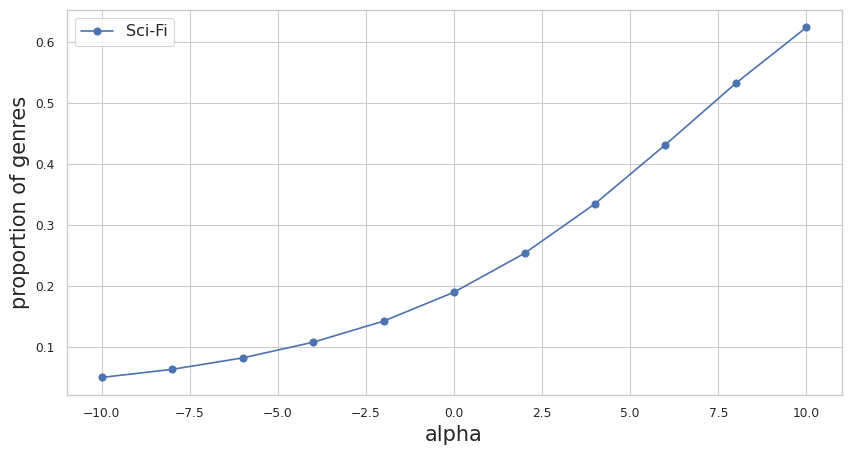

In [76]:
for genre in genres:
    subset = pd.DataFrame(results_norm)[genre].loc[f'{genre}_reconstructed']
    plt.plot(list(range(-10, 11, 2)), subset.values, label=genre, marker='o') 
    print(genre)
    #sns.lineplot(x=np.arange(-10, 11), y=subset.values, label=genre, marker='o')

plt.legend(fontsize="large")
plt.xlabel('alpha', fontsize=15)
plt.ylabel('proportion of genres', fontsize=15)
#plt.savefig('data/graphics/genres_all.png')

Text(0, 0.5, 'Inter-List Diversity@10')

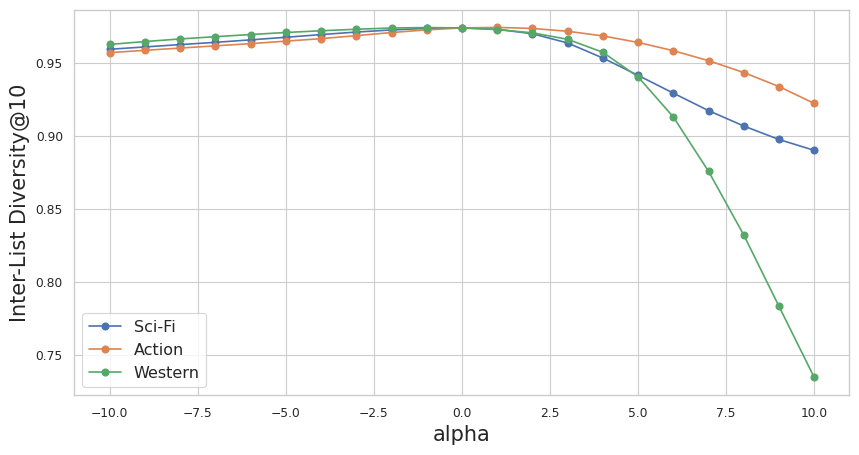

In [153]:
for genre in genres:
    subset = pd.DataFrame(results_norm)[genre].loc['Inter-List Diversity10']
    plt.plot(np.arange(-10, 11), subset.values, label=genre, marker='o')
    plt.legend()
    
plt.legend(fontsize="large")
plt.xlabel('alpha', fontsize=15)
plt.ylabel('Inter-List Diversity@10', fontsize=15)

Text(0, 0.5, 'NDCG@10')

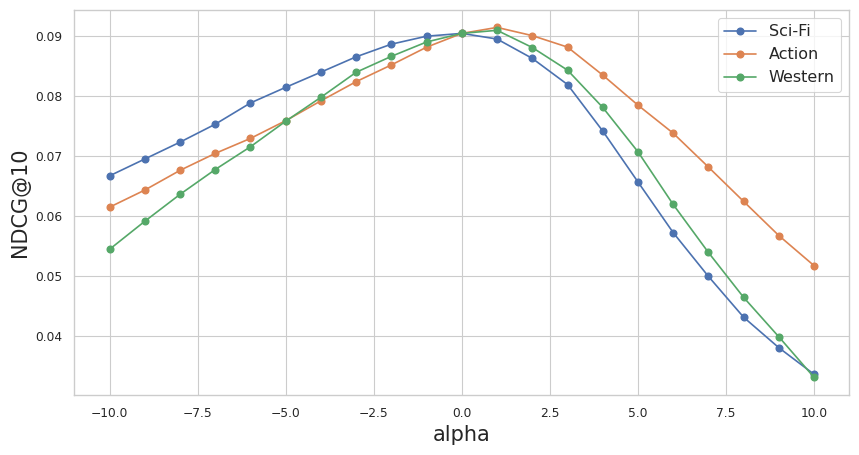

In [154]:
for genre in genres:
    subset = pd.DataFrame(results_norm)[genre].loc['NDCG@10']
    plt.plot(np.arange(-10, 11), subset.values, label=genre, marker='o')
    plt.legend()

plt.legend(fontsize="large")
plt.xlabel('alpha', fontsize=15)
plt.ylabel('NDCG@10', fontsize=15)

Text(0, 0.5, 'Coverage@10')

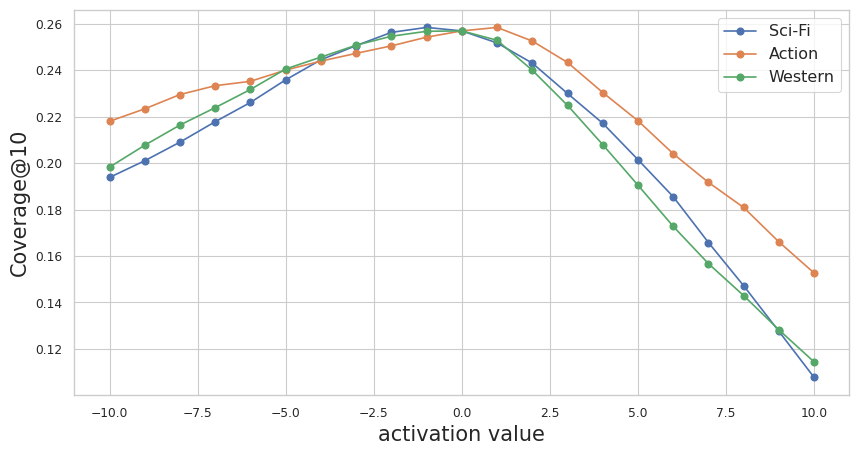

In [155]:
for genre in genres:
    subset = pd.DataFrame(results_norm)[genre].loc['Coverage@10']
    plt.plot(np.arange(-10, 11), subset.values, label=genre, marker='o')
    plt.legend()

plt.legend(fontsize="large")
plt.xlabel('activation value', fontsize=15)
plt.ylabel('Coverage@10', fontsize=15)

In [157]:
for genre in genres:
    subset = pd.DataFrame(results_norm)[genre]
    subset_fil = subset[list(filter(lambda x: ('reconstructed' in x), list(subset.columns)))]
    subset_fil = subset_fil.loc[:, abs(subset_fil.max() - subset_fil.min()) >= 0.25]
    subset_fil['neuron_value'] =  subset['neuron_value']
    
    for j in list(subset_fil.columns)[:-1]:
        plt.plot(np.arange(-10, 11), subset_fill.values, label=genre, marker='o') 
        #sns.lineplot(data=subset_fil, x="neuron_value", y=j, label=j[:-8], marker='o')
    
    plt.legend(fontsize="x-large")
    plt.title(genre.replace('_', '-'), fontsize="xx-large")
    plt.xlabel('Activation value', fontsize=17)
    plt.ylabel('Proportion of genres', fontsize=17)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
    #plt.savefig(f'data/graphics/genres_5_graphics_{genre}.png')
    plt.show()

TypeError: argument of type 'int' is not iterable

In [77]:
a = np.array([1, -2, 0, 5]) / 0.5
a

array([ 2., -4.,  0., 10.])

In [80]:
import math

In [81]:
math.e^a

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [86]:
b = np.power(math.e, a) / sum(np.power(math.e, a))
b

array([3.35334633e-04, 8.31211451e-07, 4.53826075e-05, 9.99618452e-01])

In [90]:
sum(b*np.log2(1/b))

0.005092369204085085

In [91]:
0.2*math.sqrt(0.21)+0.35

0.4416515138991168

In [92]:
3 * 3 * 3 * 8 + 8

224

In [93]:
3 * 3 * 8 * 16 + 16

1168

In [100]:
np.log2((0.03)/(0.05*0.07))

3.099535673550914

In [98]:
np.log10(9.666)

0.9852467908028617

In [101]:
((7.84)/27) - (11.8/27)**2

0.09936899862825788